<a href="https://colab.research.google.com/github/nanopiero/PREAC/blob/main/TestPerceiver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Test Perceiver :
I) Régression
II) Fusion

In [2]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')

In [3]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [6]:
import torch
import numpy as np
from random import randint
import matplotlib.pyplot as plt
import os

#############################################################
#pour la visualisation des images ###########################
#############################################################

def voir_mat(data2, fig, min_scale=-10,max_scale=70):

    ax = fig.add_subplot(1,1,1)
    ax.set_aspect('equal')
    plt.imshow(data2, interpolation='nearest', cmap=plt.cm.rainbow) #cmap=plt.cm.ocean)
    plt.clim(min_scale,max_scale)
    plt.colorbar()
    plt.show()

def voir_tens(image, fig, min_scale=-1,max_scale=1):
    im=image[0,0,:,:].numpy()
    ax = fig.add_subplot(1,1,1)
    ax.set_aspect('equal')
    plt.imshow(im, interpolation='nearest',  cmap=plt.cm.rainbow) #cmap=plt.cm.ocean)
    plt.clim(min_scale,max_scale)
    plt.colorbar()
    plt.show()

def conc(image1,image2,dim=3):
    return torch.cat((image1,image2), dim) #, out=None)

def multi_conc(L,dim=1,ecart=5, min_scale=0.5):
    image1=L[0]
    for i in range(1, len(L)):
        if dim==1:
            sep=  min_scale + 0*image1[:,0:ecart]
        elif dim==0:
            sep=  min_scale + 0*image1[0:ecart,:]
        image1=conc(image1,sep,dim)
        image2=L[i]
        image1=conc(image1,image2,dim=dim)
    return image1

def images_from_tenseur(tens, k=0):
    len_batch=tens.shape[0]
    L=[]
    for i in range(len_batch):
        L.append(tens[i,k,:,:])
    return L

def voir_batch2D(tens, nx, fig,k=0, min_scale=-10,max_scale=1):
    s = 0.5*(min_scale + max_scale)
    L=images_from_tenseur(tens,k)
    image1=multi_conc(L[0:nx],dim=1, min_scale=s)
    for i in range(1,int(len(L)/nx)):
        image2=multi_conc(L[i*nx:(i+1)*nx],dim=1, min_scale=s)
        image1=multi_conc([image1,image2],dim=0, min_scale=s)
    voir_mat(image1, fig, min_scale,max_scale)


#############################################################
#pour la génération des images    ###########################
#############################################################

def simu_rec(image, L,l,  fields=0):
    channels,size,size2=image.size()
    rec= torch.zeros(channels,size,size2)
    #out = 0*(image.clone())
    vertical=np.random.binomial(1,0.5)==1
    if vertical:
        width=l
        height=L
    else:
        width=L
        height=l

    top=randint(0, size-height)
    left=randint(0, size-width)
    rec[fields,top:top+height,left:left+width]=  np.random.uniform(0,0.4)   #0.1
    image=image + rec
    return image

def simu_noisy_rec(image, L,l,  fields=0):
    channels,size,size2=image.size()
    rec= torch.zeros(channels,size,size2)
    #out = 0*(image.clone())
    vertical=np.random.binomial(1,0.5)==1
    if vertical:
        width=l
        height=L
    else:
        width=L
        height=l

    top=randint(0, size-height)
    left=randint(0, size-width)
    rec[fields,top:top+height,left:left+width]= np.random.uniform(0,0.4)  #0.1
    noise=torch.randn(channels,size,size2)
    noise=noise*(noise>0).float()
    rec=noise*rec
    image=image + rec
    return image

def simu_disc(image, f, radius=15, fields=0 ):  #radial decrease function  #or 12
    channels,size,size2=image.size()
    center=np.array([randint(radius, size-radius) , randint(radius, size-radius) ])
    npdisc= f( ((np.arange(0,64)*np.ones([size,size])) - center[0])**2 + (np.transpose(np.arange(0,64)*np.ones([size,size]))-center[1])**2  , radius)
    npdisc=np.random.uniform(0.6,1.) * npdisc  #variation on intensity
    image[fields,:,:] = image[fields,:,:] + torch.from_numpy(npdisc).float()   #matrice des distances < rayon
    return image

def simu_disc_with_cond(image, f, radius=15, fields=0, f2 = lambda a,x  : ((np.sin(3.1 * a/x**2)))*(a < x**2) ):  #radial decrease function  #or 12
    channels,size,size2=image.size()
    center=np.array([randint(radius-5, size-radius+2) , randint(radius-2, size-radius+5) ])
    npdisc= f( ((np.arange(0,64)*np.ones([size,size])) - center[0])**2 + (np.transpose(np.arange(0,64)*np.ones([size,size]))-center[1])**2  , radius)
    npdisc=np.random.uniform(0.6,1.) * npdisc  #variation on intensity
    image[0,:,:] = image[0,:,:] + torch.from_numpy(npdisc).float()   #matrice des distances < rayon
    if (radius >= 10) and (radius <= 14):
        npdon = f2( ((np.arange(0,64)*np.ones([size,size])) - center[0])**2 + (np.transpose(np.arange(0,64)*np.ones([size,size]))-center[1])**2  , radius)
        image[1,:,:] = image[1,:,:] + torch.from_numpy(npdon).float()**2
    return image


def simu_square(image, f, diag=15, fields=0 ):  #radial decrease function  #or 12
    channels,size,size2 = image.size()
    center=np.array([randint(diag, size-diag) , randint(diag, size-diag) ])

    npsquare = f(  np.abs(np.arange(0,64)*np.ones([size,size]) - center[0]) + \
                   np.abs(np.transpose(np.arange(0,64)*np.ones([size,size]))-center[1]), diag)
#    npsquare = np.abs(np.arange(0,64)*np.ones([size,size]) - center[0])
    npsquare = np.random.uniform(0.6,1.) * npsquare  #variation on intensity
    image[fields,:,:] = image[fields,:,:] + torch.from_numpy(npsquare).float()   #matrice des distances < rayon
    return image


def plot_pairs(image, f = lambda x : x**2):
    horizontal = (torch.randint(0,2,(1,)) > 0.5).item()
#    print(horizontal)
    dist = torch.randint(1,32, (1,)).item()
    if horizontal :
        ordo = torch.randint(0, 64, (1,)).item()
        absi = torch.randint(0, 64 - dist, (1,)).item()
        image[1, ordo, absi:(absi + dist + 1)] \
            += 0.1 + torch.mean(f(image[0, ordo, absi:(absi + dist + 1)]))
    else :
        ordo = torch.randint(0, 64 - dist, (1,)).item()
        absi = torch.randint(0, 64, (1,)).item()
        image[1, ordo:ordo+dist+1, absi] \
            += 0.1 + torch.mean(f(image[0, ordo:ordo+dist+1, absi]))
    return image



def make_image(rec, noisy_rec ,disc,square=0., pola=[0]):
    image=torch.zeros([1,64, 64])
    image = generate_noise(image, lambda_rec=rec, lambda_noisy_rec = noisy_rec,lambda_disc = disc, lambda_square = square, pola= pola)
    return image

def make_image_with_cond(rec, noisy_rec ,disc,square=0., pola=[0]):
    image = torch.zeros([2, 64, 64])
    image = generate_noise_with_cond(image, lambda_rec=rec, lambda_noisy_rec = noisy_rec,lambda_disc = disc, lambda_square = square, pola= pola)
    return image

def make_batch(batch_size, rec, noisy_rec ,disc, square=0., pola=[0] ):
    out = make_image(rec, noisy_rec ,disc , square, pola ).unsqueeze(0)
    for i in range(batch_size-1):
        new=make_image(rec, noisy_rec ,disc, square, pola).unsqueeze(0)
        out=torch.cat((out,new), dim=0)
    return out

def make_batch_with_cond(batch_size, rec, noisy_rec ,disc, square=0.):
    out = make_image_with_cond(rec, noisy_rec ,disc , square).unsqueeze(0)
    for i in range(batch_size-1):
        new=make_image_with_cond(rec, noisy_rec ,disc, square).unsqueeze(0)
        out=torch.cat((out,new), dim=0)
    return out

def make_image_with_pairs(rec, freq_integrated_signals, noisy_rec ,disc,square=0., pola=[0]):
    image=torch.zeros([1,64, 64])
    image = generate_noise_and_pairs(image, lambda_pairs=freq_integrated_signals,
                                     lambda_rec=rec, lambda_noisy_rec=noisy_rec,
                                     lambda_disc=disc, lambda_square=square,
                                     pola= pola)
    return image

def make_batch_with_pairs(batch_size, freq_integrated_signals, rec, noisy_rec,
                                disc, square=0., pola=[0]):
    out=make_image_with_pairs(rec, freq_integrated_signals, noisy_rec,
                              disc , square, pola ).unsqueeze(0)
    for i in range(batch_size - 1):
        new=make_image_with_pairs(rec, freq_integrated_signals, noisy_rec, disc, square, pola).unsqueeze(0)
        out=torch.cat((out,new), dim = 0)
    return out


##############################################################################################
################################       spécifique au TP     ##################################

def gen(n):  #exercice 1 partie 1
  target = make_batch(n, rec = 0., noisy_rec= 0., disc = 0.002)
  noise =  make_batch(n, rec = 0.0003, noisy_rec= 0.0003, disc = 0.)
  return  target + noise, target     #bruit additif trivial

def gen_noise2noise(n):
  target = make_batch(n, rec = 0., noisy_rec= 0., disc = 0.002)
  noise1 =  make_batch(n, rec = 0.0005, noisy_rec= 0.0005, disc = 0.)
  noise2 =  make_batch(n, rec = 0.0005, noisy_rec= 0.0005, disc = 0.)
  return  target + noise1, target + noise2

def gen1_NES(n):
  noisy_image = make_batch(n, rec = 0.0003, noisy_rec= 0.0003, disc = 0.002)
  return  noisy_image

def gen2_NES(n):
  noise1 =  make_batch(n, rec = 0.0003, noisy_rec= 0.0003, disc = 0.)
  return  noise1


def gen_proba(n):
  target1 = make_batch(n, rec = 0., noisy_rec= 0., disc = 0.001)
  m1 = torch.normal(target1**2, 0.2*target1)
  input = target1
  target =   m1
  return  input, target

def gen_ponct(n, p = 0.01):
  input = make_batch(n, rec = 0., noisy_rec= 0., disc = 0.001)
  fulltarget = 2*input**2
  sb = torch.bernoulli(0*fulltarget + p)         # En moyenne,2% des pixels sont couverts par une mesure ponctuelle

  #cible fragmentaire
  target = fulltarget*(sb) + (-1)*(1 - sb)

  return  input, target, fulltarget


def gen_condDCGAN(n, p = 0.01):
  x = make_batch(n, rec = 0., noisy_rec= 0., disc = 0.001, square = 0.)
  fulltarget = x #2*x**2
#  sb = (make_batch(n, rec = 0., noisy_rec= 0., disc = p, square = 0.)> 0.1
  sb = torch.bernoulli(0*fulltarget + p)         # En moyenne,2% des pixels sont couverts par une mesure ponctuelle
  #cond (ex. cible fragmentaire)
  y = fulltarget*sb + (-0.1)*(1 - sb)

  z = torch.randn(*fulltarget.size())
  return  x, y, z


def gen_DCGAN(n, lambda_rec = 0.):
  x = make_batch(n, rec = lambda_rec, noisy_rec= 0., disc = 0.001, square = 0.)
  fulltarget = x #2*x**2

  z = torch.randn(*fulltarget.size())
  return  x, z


def gensquare_condDCGAN(n, p = 0.01):
  x = make_batch(n, rec = 0., noisy_rec= 0., disc = 0., square = 0.001)
  fulltarget = x #2*x**2
  sb = torch.bernoulli(0*fulltarget + p)         # En moyenne,2% des pixels sont couverts par une mesure ponctuelle
  #cond (ex. cible fragmentaire)
  y = fulltarget*sb + (-1)*(1 - sb)

  z = torch.randn(*fulltarget.size())
  return  x, y, z

def gen_cycleGAN(n, lambda_disc = 0.001, lambda_square = 0.001):
  Adiscs = make_batch(n, rec = 0., noisy_rec= 0., disc = lambda_disc, square = 0.)
  Bsquares = make_batch(n, rec = 0., noisy_rec= 0., disc = 0., square = lambda_square)
  return  Adiscs, Bsquares


def gen_mixt(n, p = 0.02):
  target1 = make_batch(n, rec = 0., noisy_rec= 0., disc = 0.001)
  target2 = make_batch(n, rec = 0., noisy_rec= 0., disc = 0.001)
  s1 = 0.4*target1  #premier type de cellule: signal-cible faible
  s2 = 1.6*target2  #second type: signal-cible fort
  sb = torch.bernoulli(0*target1 + p)         # En moyenne,2% des pixels sont couverts par une mesure ponctuelle

  #noise =  make_batch(n, rec = 0.0003, noisy_rec= 0.0003, disc = 0.)

  input = target1 + target2
  fulltarget =   s1 + s2

  #cible fragmentaire
  target = fulltarget*sb + (-1)*(1 - sb)

  return  input, target, fulltarget


  def simu_1disc(image, mean, sigma, f, radius=15, fields=0 ):  #radial decrease function  #or 12
    channels,size,size2=image.size()
    center=np.array([randint(radius, size-radius) , randint(radius, size-radius) ])
    npdisc= f( ((np.arange(0,64)*np.ones([size,size])) - center[0])**2 + (np.transpose(np.arange(0,64)*np.ones([size,size]))-center[1])**2  , radius)
    npdisc = torch.from_numpy(npdisc).float()
    noise = torch.randn(channels,size,size2)
    npdisc = (mean + sigma*noise)* npdisc   #bruitage du disque
    image[fields,:,:] = image[fields,:,:] + npdisc   #matrice des distances < rayon
    return image

def make_image2():
    image=torch.zeros([1,64, 64])
    f = lambda a,x  : (a < x**2)
    r = randint(5,10)
    rplus = randint(5,8)
    md0= np.random.uniform(0,1)
    md1= np.random.uniform(0,1)
    image=simu_1disc(image, md0, 0, f  ,radius = r)
    image=simu_1disc(image, md1, 0, f  ,radius = r+rplus)
#    L=randint(50,60)
#    l=randint(2,10)
#    image= simu_rec(image,L,l)
    return image.unsqueeze(0), torch.tensor(md0).reshape((1,1))

def gen_paires(batch_size):
    out0,y0=make_image2()
    out1,y1=make_image2()

    for i in range(batch_size-1):
        new0,newy0=make_image2()
        out0=torch.cat((out0,new0), dim=0)
        y0=torch.cat((y0,newy0), dim=0)
        new1,newy1=make_image2()
        out1=torch.cat((out1,new1), dim=0)
        y1=torch.cat((y1,newy1), dim=0)
    return out0,out1, (y0<y1).int(), y0, y1


def gen_image_with_integrated_signals(batch_size, p):
    freq_integrated_signals = 0.005
    image = make_batch_with_pairs(batch_size, freq_integrated_signals
                                  0, 0 ,0.001, square=0., pola=[0] )
    full_target = image[:,[0],:,:] #2*x**2
    sb = torch.bernoulli(0*full_target + p)         # En moyenne,2% des pixels sont couverts par une mesure ponctuelle
    #cond (ex. cible fragmentaire)
    partial_target = full_target*sb + (-1)*(1 - sb)
    integrated_signals = image[:,[1],:,:]

    return full_target, partial_target, integrated_signals


def gen_pointnet(n):
  target = make_batch(n, rec = 0., noisy_rec= 0., disc = 0.0005)
  noise =  make_batch(n, rec = 0.001, noisy_rec= 0., disc = 0.)
  return  target + noise, target     #bruit additif trivial

def generate_noise(image, lambda_rec=0.001 ,lambda_noisy_rec = 0.001, lambda_disc = 0.001, lambda_square = 0., pola=[0,0.5,0.1]):
    for k in range(np.random.poisson(lambda_disc*64*64)):
        r = randint(5,10)
        image=simu_disc(image, lambda a,x  : (0.39 - 0.36*a/x**2)*(a < x**2) ,radius = r)  #0.47 pour avoir 40 dB
    for k in range(np.random.poisson(lambda_square*64*64)):
        r = randint(5,10)
        image=simu_square(image, lambda a,x  : (0.5 - 0.45*a/x)*(a < x) , diag = r)  #0.47 pour avoir 40 dB
#        print(r)

    for i in range(np.random.poisson(lambda_rec*64*64)):
        L=randint(20,50)
        l=randint(2,10)
        image= simu_rec(image,L,l)
    for j in range(np.random.poisson(lambda_noisy_rec*64*64)):
        L=randint(10,30)
        l=randint(10,30)
        image= simu_noisy_rec(image,L,l)
        # 0.3*np.exp(-0.1 * a/x)*(a < x**2)  #image=simu_disque(image, lambda a,x  : 1.0*(a < x**2)  )
    if pola[0]==1:      #add a pseudo pola field
        image_pola = generate_pola(image,pola)
        image=torch.cat([image,image_pola],dim=0)
    return image


def generate_noise_with_cond(image, lambda_rec=0.001 ,lambda_noisy_rec = 0.001, lambda_disc = 0.001, lambda_square = 0., pola=[0,0.5,0.1]):
    for k in range(np.random.poisson(lambda_disc*64*64)):
        r = randint(6,18)
        image=simu_disc_with_cond(image, lambda a,x  : (0.39 - 0.36*a/x**2)*(a < x**2) ,radius = r)  #0.47 pour avoir 40 dB
    for k in range(np.random.poisson(lambda_square*64*64)):
        r = randint(5,10)
        image=simu_square(image, lambda a,x  : (0.5 - 0.45*a/x)*(a < x) , diag = r)  #0.47 pour avoir 40 dB
#        print(r)

    for i in range(np.random.poisson(lambda_rec*64*64)):
        L=randint(20,50)
        l=randint(2,10)
        image= simu_rec(image,L,l)
    for j in range(np.random.poisson(lambda_noisy_rec*64*64)):
        L=randint(10,30)
        l=randint(10,30)
        image= simu_noisy_rec(image,L,l)
        # 0.3*np.exp(-0.1 * a/x)*(a < x**2)  #image=simu_disque(image, lambda a,x  : 1.0*(a < x**2)  )
    return image


def generate_noise_and_pairs(image, lambda_pairs=0.01, lambda_rec=0.001,
                             lambda_noisy_rec=0.001, lambda_disc=0.001,
                             lambda_square=0., pola=[0,0.5,0.1]):
    for k in range(np.random.poisson(lambda_disc*64*64)):
        r = randint(5,10)
        image=simu_disc(image, lambda a,x  : (0.39 - 0.36*a/x**2)*(a < x**2) ,radius = r)  #0.47 pour avoir 40 dB
    for k in range(np.random.poisson(lambda_square*64*64)):
        r = randint(5,10)
        image=simu_square(image, lambda a,x  : (0.5 - 0.45*a/x)*(a < x) , diag = r)  #0.47 pour avoir 40 dB
#        print(r)
    for i in range(np.random.poisson(lambda_rec*64*64)):
        L=randint(20,50)
        l=randint(2,10)
        image= simu_rec(image,L,l)
    for j in range(np.random.poisson(lambda_noisy_rec*64*64)):
        L=randint(10,30)
        l=randint(10,30)
        image = simu_noisy_rec(image,L,l)
        # 0.3*np.exp(-0.1 * a/x)*(a < x**2)  #image=simu_disque(image, lambda a,x  : 1.0*(a < x**2)  )
    # on ajoute le deuxième canal où les échanges entre signaux seront
    # représentés

    image2 = torch.zeros([1,64, 64])
    image = torch.cat([image, image2], dim = 0 )

    for j in range(np.random.poisson(lambda_pairs * 64 * 64)):
        image = plot_pairs(image)

    return image

SyntaxError: expected ':' (<ipython-input-6-366599ff5805>, line 154)

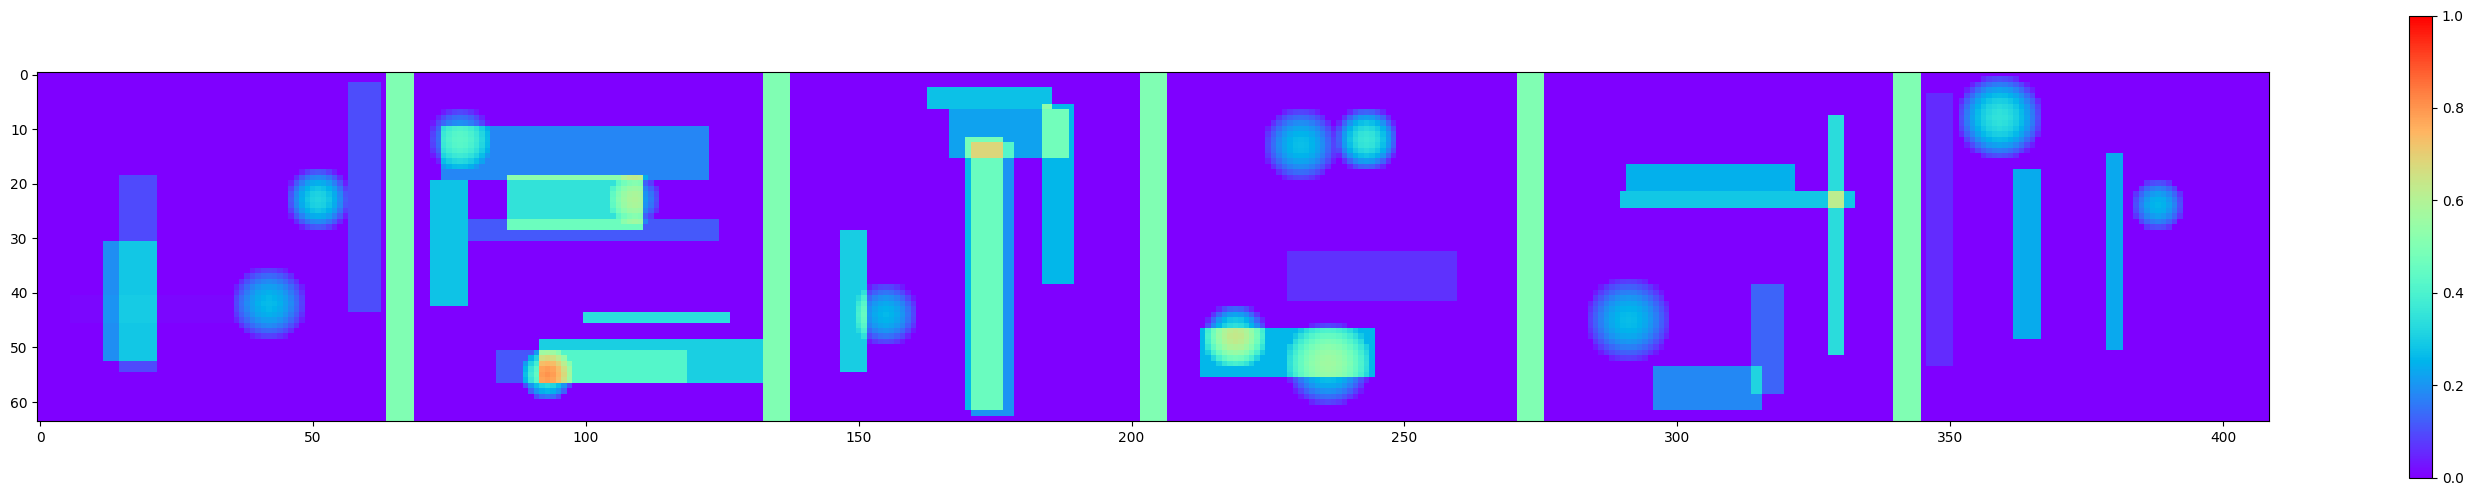

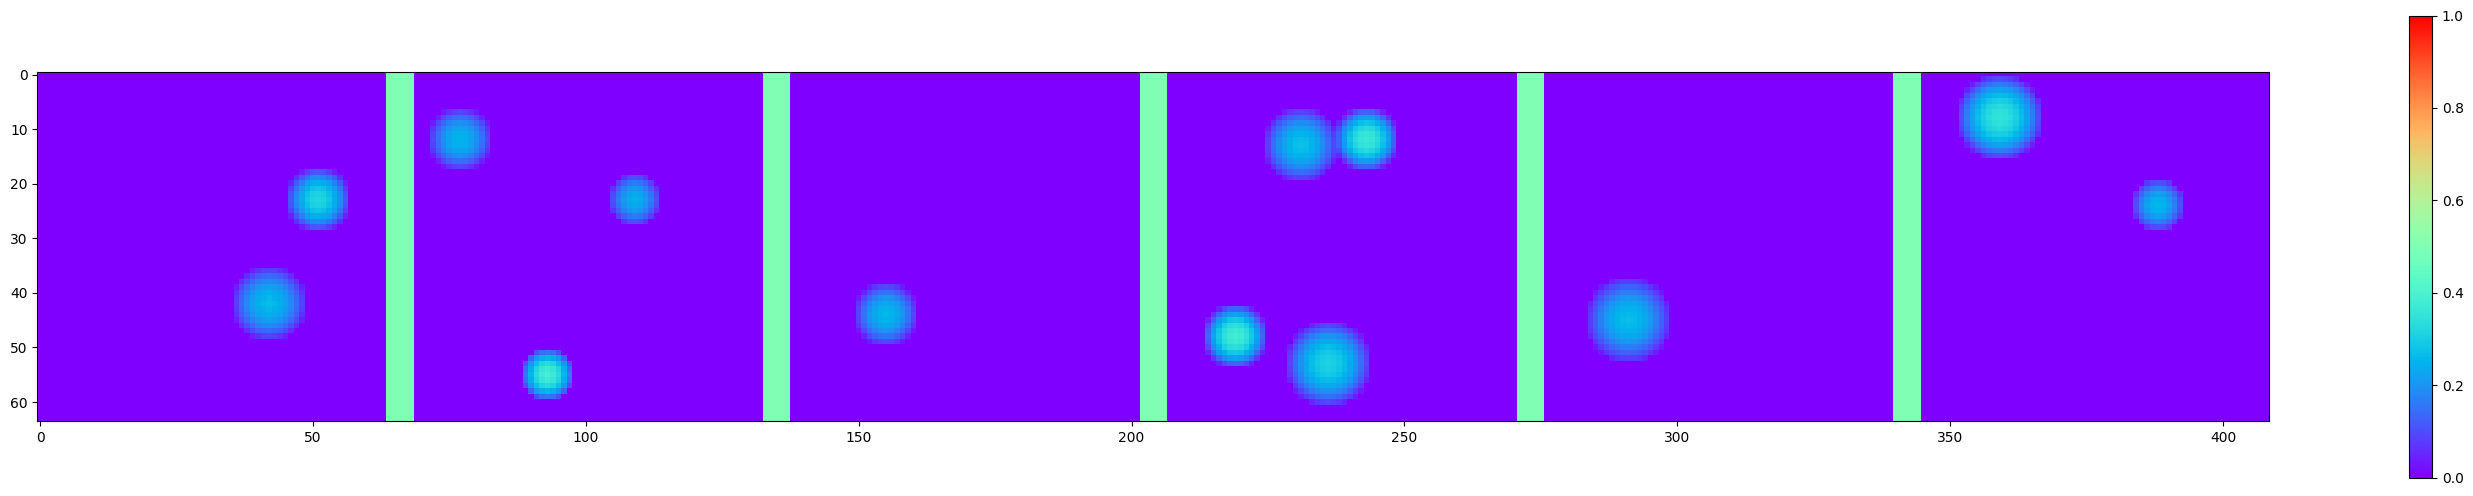

In [5]:
batch_size = 6


x, y  = gen_pointnet(batch_size)


fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(x, 6, fig1, k=0, min_scale=0, max_scale=1)


fig2 = plt.figure(2, figsize=(36, 6))
voir_batch2D(y, 6, fig2, k=0, min_scale=0, max_scale=1)

# Fusion de données :


In [18]:
! pip install numba

In [19]:
from numba import jit



@jit(nopython=True)
def get_equation(coords_1, coords_2):
  # rustine pour éviter les pbs. lon lat étant données à 10-5 près:
  eps = 10**-5
  if coords_2[0] == coords_1[0] :
      m = (coords_2[1] - coords_1[1]) / (eps + coords_2[0] - coords_1[0])
  elif coords_2[1] == coords_1[1] :
      m = (eps + coords_2[1] - coords_1[1]) / (coords_2[0] - coords_1[0])
  else:
      m = (coords_2[1] - coords_1[1]) / (coords_2[0] - coords_1[0])
  a =  -m
  b =  1
  c =  m*coords_1[0]  - coords_1[1]
  return a,b,c



@jit(nopython=True)
def get_dists(coords_1, coords_2, matrix):

  """
  Compute intersection length between
  [coords_1, coords_2] and pixel_ij
  should have: coords_1[0] < coords_2[0]
  """
  a, b, c = get_equation(coords_1, coords_2)
  # print("equation :", a, b ,c)
  N,M = matrix.shape
  # Indx = np.arange(0,M).reshape(1,M).repeat(N,axis = 0)
  # Indy = np.arange(N-1,-1,-1).reshape(N,1).repeat(M,axis = 1)

  Indx = np.arange(0,M).repeat(N).reshape(M,N).transpose((1,0))
  Indy = np.arange(N-1,-1,-1).repeat(M).reshape(N,M)

  # print(Indx == np.arange(0,M).repeat(N).reshape(M,N).transpose((1,0)))
  # print(Indy == np.arange(N-1,-1,-1).repeat(M).reshape(N,M))
  # raise Exception('')

  inds_1 = (np.ceil(coords_1[0]), np.ceil(coords_1[1]))
  inds_2 = (np.ceil(coords_2[0]), np.ceil(coords_2[1]))

  coord_l = min(coords_1[0], coords_2[0])
  coord_r = max(coords_1[0], coords_2[0])
  coord_d = min(coords_1[1], coords_2[1])
  coord_u = max(coords_1[1], coords_2[1])

  eps = 10**-6
  ind_l = int(np.floor(coord_l))
  ind_r = int(np.floor(coord_r - eps))
  ind_d = int(np.floor(coord_d))
  ind_u = int(np.floor(coord_u - eps))


  # for each pixel i,j: the sign of Mld[i,j]
  # gives the relative position of the left/down corner
  # wrt the line ax + by + c = 0
  Mld = (a * Indx + b * Indy + c)
  Mrd = (a * (Indx + 1) + b * Indy + c)
  Mlu = (a * Indx + b * (Indy + 1) + c)
  Mru = (a * (Indx + 1) + b * (Indy + 1) + c)

  # intersections with l/r edges :
  Xl = (Indx + 0.) #.astype(float)
  Xr = (Indx + 1.) #.astype(float)
  Yl = (- a * Indx - c) / b
  Yr = (- a * (Indx + 1) - c) / b


  # intersections with u/d edges :
  Xd = (- b * Indy - c) / a
  Xu = (- b * (Indy + 1) - c) / a
  Yd = (Indy + 0.) #.astype(float)
  Yu = (Indy + 1.) #.astype(float)

  # case of pixels 1 & 2
  if a >= 0:
    Xl[N - 1 - ind_u,ind_l] = coord_l
    Xu[N - 1 - ind_u,ind_l] = coord_l

    Xr[N - 1 - ind_d,ind_r] = coord_r
    Xd[N - 1 - ind_d,ind_r] = coord_r

    Yu[N - 1 - ind_u,ind_l] = coord_u
    Yl[N - 1 - ind_u,ind_l] = coord_u

    Yd[N - 1 - ind_d,ind_r] = coord_d
    Yr[N - 1 - ind_d,ind_r] = coord_d


  else:
    Xl[N - 1 - ind_d,ind_l] = coord_l
    Xd[N - 1 - ind_d,ind_l] = coord_l

    Xr[N - 1 - ind_u,ind_r] = coord_r
    Xu[N - 1 - ind_u,ind_r] = coord_r

    Yu[N - 1 - ind_u,ind_r] = coord_u
    Yr[N - 1 - ind_u,ind_r] = coord_u

    Yd[N - 1 - ind_d,ind_l] = coord_d
    Yl[N - 1 - ind_d,ind_l] = coord_d


  # Building distance matrix
  Dists = 0. * Xl
  # lu : path between lu, ld & lu, ru
  Mask = ((Mlu * Mld < 0) * (Mlu * Mru <= 0))
  Dists += np.sqrt((Xl - Xu)**2 + (Yl - Yu)**2) * Mask

  # lr : path between lu, ld & ru, rd
  Mask = (Mlu * Mld < 0) * (Mru * Mrd < 0)
  Dists += np.sqrt((Xl - Xr)**2 + (Yl - Yr)**2) * Mask

  # ld : path between lu, ld & ld, rd
  Mask = (Mlu * Mld < 0) * (Mld * Mrd <= 0)
  Dists += np.sqrt((Xl - Xd)**2 + (Yl - Yd)**2) * Mask

  # ur : path between lu, ru & ru, rd
  Mask = (Mlu * Mru <= 0) * (Mru * Mrd < 0)
  Dists += np.sqrt((Xu - Xr)**2 + (Yu - Yr)**2) * Mask

  # ud : path between lu, ru & ld, rd
  Mask = (Mlu * Mru <= 0) * (Mld * Mrd <= 0)
  Dists += np.sqrt((Xu - Xd)**2 + (Yu - Yd)**2) * Mask

  # rd : path between ld, rd & ru, rd
  Mask = (Mld * Mrd <= 0) * (Mru * Mrd < 0)
  Dists += np.sqrt((Xr - Xd)**2 + (Yr - Yd)**2) * Mask

  # clean outside the segment :
  Mask = (Indx >= ind_l) * (Indx <= ind_r)
  Dists *= Mask

  Mask = (Indy >= ind_d) * (Indy <= ind_u)
  Dists *= Mask

  return Dists

@jit(nopython=True)
def create_pairs(image, n_pairs = 3, f = lambda x : x**2):
  distx = torch.randint(0,32, (n_pairs,))
  disty = torch.randint(-15, 16, (n_pairs,))

  perceived_image = f(image[0,:,:])
  trace =  image[1,:,:]
  pairs = []
  for i in range(n_pairs):

    coli0 = np.randint(0, 64 - distx[i], (n_pairs,)).item()
    rowi0 = np.randint(max(0, 0 - disty[i]), min(64, 64 - disty[i]), (1,)).item()
    coli1 = xi0 + distx[i]
    rowi1 = coli0 + disty[i]

    if row0 > row1:
      row_max = row0
      row_min = row1
    else:
      row_max = row0
      row_min = row1

    yi0 = rowi0 + np.rand(1)
    yi1 = rowi0 + np.rand(1)
    xi0 = coli0 + np.rand(1)
    xi1 = coli1 + np.rand(1)

    cropi = perceived_image[row_min:row_max+1,coli0:coli1+1]
    distsi = get_dists((xi0, yi0), (xi1, yi1), cropi)
    meani = np.sum(distsi * cropi) / np.sum(distsi)
    trace[row_min:row_max+1,coli0:coli1+1] += meani * (distsi > 0)
    pairs.append((xi0, yi0), (xi1, yi1), meani)

  return image, pairs




def generate_image(image, lambda_pairs=0.01, lambda_rec=0.001,
                             lambda_noisy_rec=0.001, lambda_disc=0.001,
                             lambda_square=0., pola=[0,0.5,0.1]):
    for k in range(np.random.poisson(lambda_disc*64*64)):
        r = randint(5,10)
        clean_image=simu_disc(image, lambda a,x  : (0.39 - 0.36*a/x**2)*(a < x**2) ,radius = r)  #0.47 pour avoir 40 dB
    for k in range(np.random.poisson(lambda_square*64*64)):
        r = randint(5,10)
        image=simu_square(clean_image, lambda a,x  : (0.5 - 0.45*a/x)*(a < x) , diag = r)  #0.47 pour avoir 40 dB
#        print(r)
    for i in range(np.random.poisson(lambda_rec*64*64)):
        L=randint(20,50)
        l=randint(2,10)
        image= simu_rec(image,L,l)
    for j in range(np.random.poisson(lambda_noisy_rec*64*64)):
        L=randint(10,30)
        l=randint(10,30)
        image = simu_noisy_rec(image,L,l)
        # 0.3*np.exp(-0.1 * a/x)*(a < x**2)  #image=simu_disque(image, lambda a,x  : 1.0*(a < x**2)  )
    # on ajoute le deuxième canal où les échanges entre signaux seront
    # représentés

    image2 = torch.zeros([1,64, 64])
    image = torch.cat([image, image2], dim = 0 )

    return clean_image, image

def make_image_with_pairs(rec, freq_integrated_signals, noisy_rec ,disc,square, pola, f):
    image=torch.zeros([1,64, 64])
    image = generate_image(image, lambda_pairs=freq_integrated_signals,
                                     lambda_rec=rec, lambda_noisy_rec=noisy_rec,
                                     lambda_disc=disc, lambda_square=square,
                                     pola= pola)
    clean_image, image, pairs = create_pairs(image, n_pairs = 3, f = f)
    return clean_image, image, pairs

def make_batch_with_pairs(batch_size, freq_integrated_signals, rec, noisy_rec,
                                disc, square=0.001, pola=[0], f=lambda x : x**2):
    clean_images = []
    noisy_images = []
    pairs_list = []
    for i in range(batch_size):
        clean_image, image, pairs = make_image_with_pairs(rec, freq_integrated_signals,
                                                          noisy_rec, disc, square, pola, f).unsqueeze(0)
        clean_images.append(clean_image)
        images.append(image)
        pairs_list.append(pairs)

    clean_images=torch.cat(images, dim = 0)
    images=torch.cat(images, dim = 0)

    return clean_images, images, pairs_list

def gen_image_and_pairs(batch_size, p, f):
    freq_integrated_signals = 0.005
    clean_images, images, pairs_list = make_batch_with_pairs(batch_size, freq_integrated_signals, 0, 0 ,0.001, square=0., pola=[0], f=f)
    full_target = clean_image #2*x**2
    sb = torch.bernoulli(0*full_target + p)         # En moyenne,2% des pixels sont couverts par une mesure ponctuelle
    #cond (ex. cible fragmentaire)
    partial_target = full_target*sb + (-1)*(1 - sb)
    integrated_signals = images[:,[1],:,:]

    return full_target, partial_target, integrated_signals, pairs_list

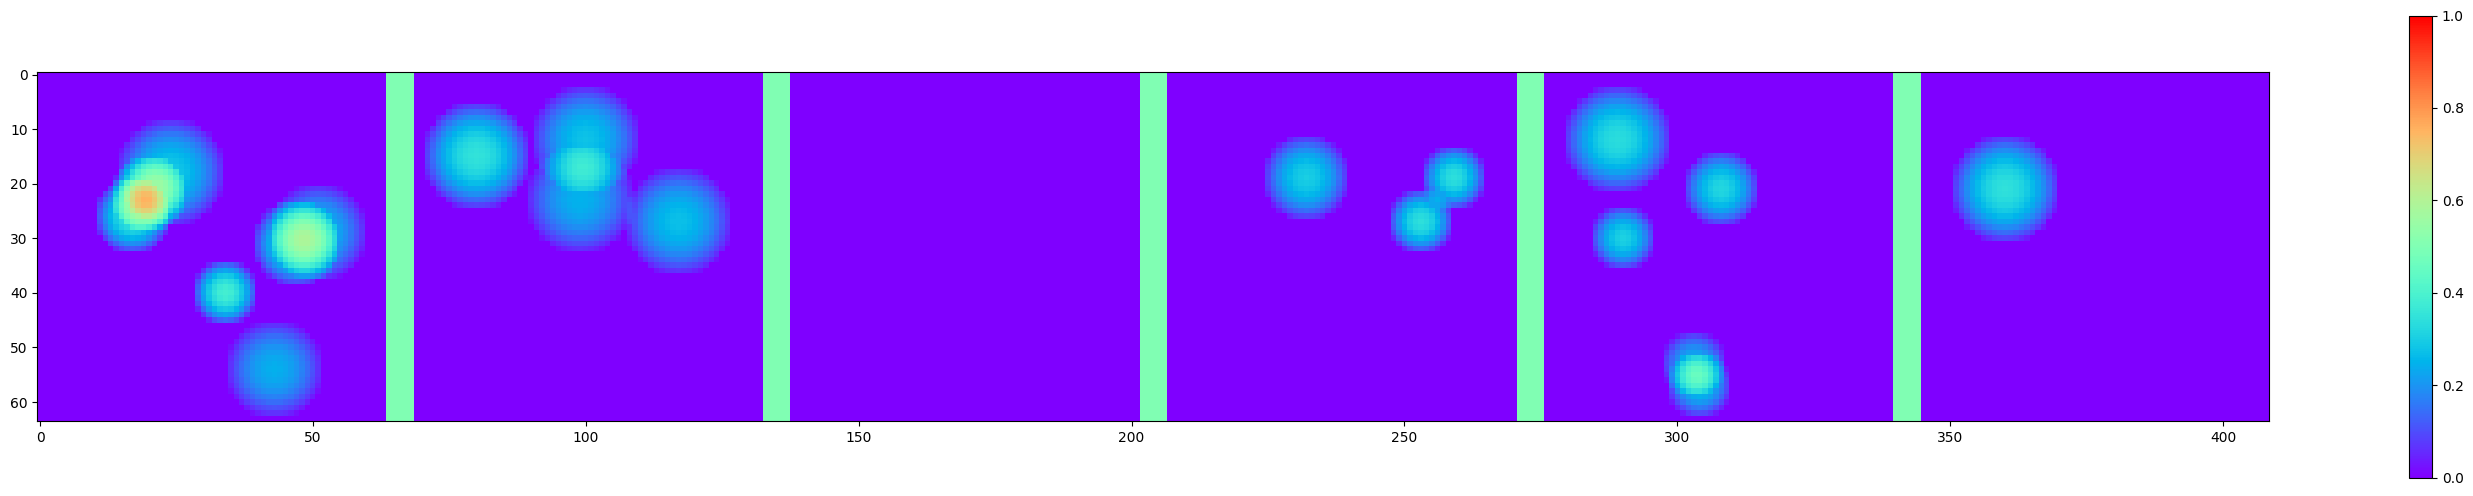

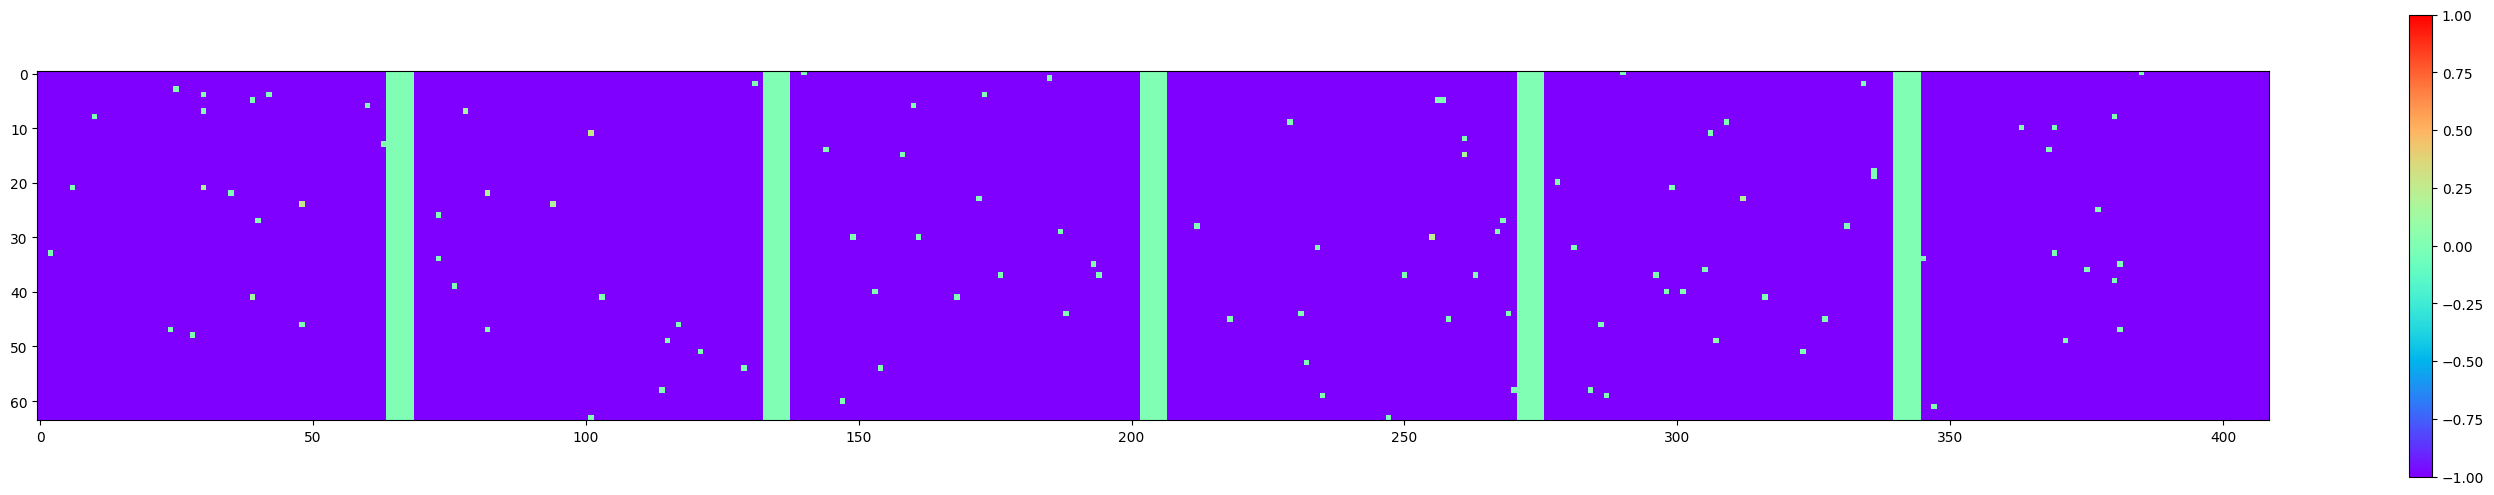

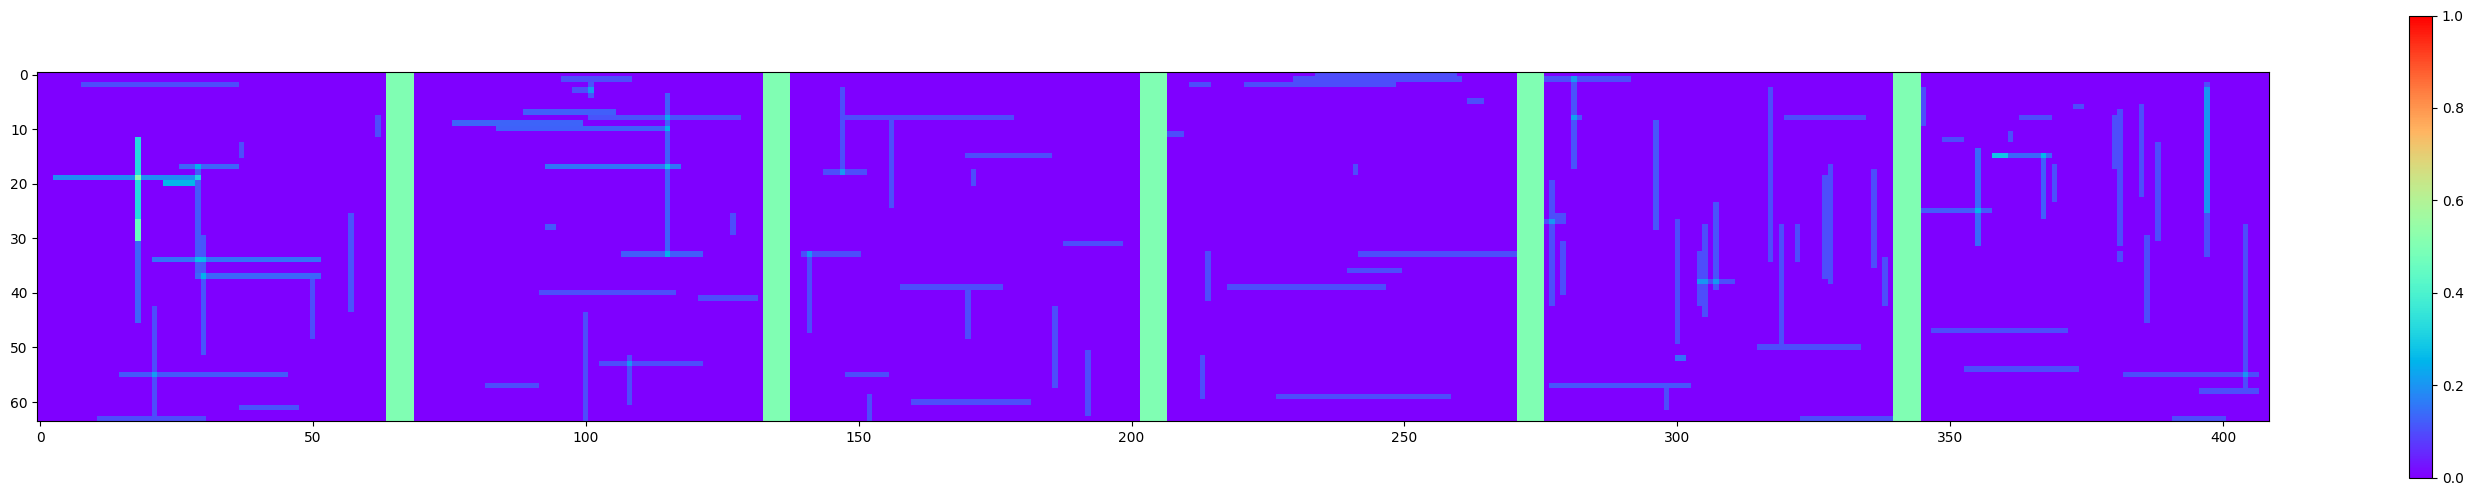

In [5]:
batch_size = 6
p = 0.5 / 100
full_target, partial_target, integrated_signals  = gen_image_with_integrated_signals(batch_size, p)


fig1 = plt.figure(1, figsize=(36, 6))
# champ T
voir_batch2D(full_target, 6, fig1, k=0, min_scale=0, max_scale=1)

# mesures ponctuelles
fig2 = plt.figure(2, figsize=(36, 6))
voir_batch2D(partial_target, 6, fig2, k=0, min_scale=-1, max_scale=1)

# représentation des données d'opportunité par des segments
fig3 = plt.figure(3, figsize=(36, 6))
voir_batch2D(integrated_signals, 6, fig3, k=0, min_scale=0, max_scale=1)

In [ ]:
full_target, partial_target, integrated_signals  = gen_image_with_integrated_signals(batch_size, p)

**Exercice 1**

**Q1** Dans la cellule suivante, instancier un UNet. Choisir correctement *ch_in* et *ch_out*.

In [ ]:
ch_in = 1
ch_out = 1
size = 8

fcn = UNet(ch_in, ch_out, size).cuda()

**Q2** Combien de poids ce réseau contient-il ? Ecrire le calcul ou intégrer un bout de code qui conduit au résultat.

In [ ]:
# Pour voir les noms des couches contenues dans UNEt
for module in fcn.modules():
    print(module.__class__.__name__)

In [ ]:
nb_weights = 0
for module in fcn.modules():
  # On compte les poids des couches qui en contiennent (attention aux doublons!):
  if isinstance(module, nn.Conv2d)\
    or isinstance(module, nn.BatchNorm2d)\
    or isinstance(module, nn.ConvTranspose2d):
    print(module.__class__.__name__)
    for parameter in module.parameters():
      nb_weights += torch.numel(parameter)
print("nb de poids : " + str(nb_weights))

# Il y a 232546 poids

**Q3** Présenter brièvement les types de couches utilisées dans ce réseau.

On trouve:
- des couches de convolutions. Ces couches sont caractérisées par des noyaux qui contiennent les poids (un neurone = un noyau). Pour cette version du UNet, chaque noyau, passé sur l'image d'entrée, fournit une carte de carastéristique de dimensions spatiales égales (ce n'est pas le cas dans un ResNet, à cause du paramètre stride>1...).
- des Maxpooling. Ici, ces couches réduisent la taille de l'image intermédiaire en prenant les valeurs maximum sur des carrés de taille 2X2, canal par canal.
- des couches de convolution transposées avec stride = 2. Elles génèrent des cartes de caractéristiques dont les dimensions spatiales sont le double de celles de l'image d'entrée.
- des fonctions d'activation non-linéaires ReLU (partie positive).

**Q4** Dans la cellule suivante, coder en une ligne l'erreur absolue moyenne.

In [ ]:
def criterion(output,target):
  return torch.mean(torch.abs(output-target))

**Q5** Instancier l'optimizer Adam avec un taux d'apprentissage de 0.0002.

In [ ]:
torch.manual_seed(0)
optimizer = optim.Adam(fcn.parameters(), 2*10**(-4))

**Q6** Pourquoi est-il nécessaire de passer par une étape de validation lors d'un apprentissage ? Pourquoi peut-on s'en passer dans le cas où les images sont générées la volée ?

Pour garantir les performances en généralisation sur le jeu de test. Autrement dit: l'étape de validation permet de s'assurer qu'il n'y a pas surapprentissage du jeu d'entraînement.

**Q7** Ecrire la boucle d'apprentissage. On stockera la MAE à chaque époque.
- nombre d'époques : 30
- batches par époque : 100
- taille de batch : 32

In [ ]:
nepochs = 30
nbatches = 100
batchsize = 32

train_losses_is = []


for epoch in range(nepochs):


    print("Epoch " + str(epoch))
    epoch_losses  = []
    for i in range(nbatches):    # nbatch = datasetsize/batchsize
        #Load inputs


        full_target, partial_target, integrated_signals = gen_image_with_integrated_signals(batch_size, p)


        input = integrated_signals.cuda()
        target = full_target.cuda()


        optimizer.zero_grad()
        output = fcn(input)

        loss = criterion(output,target)
        loss.backward()

        optimizer.step()


        epoch_losses.append(loss.detach().cpu())

        del target, input, loss
        torch.cuda.empty_cache()

    epoch_loss = np.mean(epoch_losses)
    train_losses_is.append(epoch_loss)

    print('epoch loss : \n')
    print(epoch_loss)

Epoch 0
epoch loss : 

0.108245164
Epoch 1
epoch loss : 

0.0569606
Epoch 2
epoch loss : 

0.046798274
Epoch 3
epoch loss : 

0.042883325
Epoch 4
epoch loss : 

0.04123693
Epoch 5
epoch loss : 

0.039846074
Epoch 6
epoch loss : 

0.037090622
Epoch 7
epoch loss : 

0.036452554
Epoch 8
epoch loss : 

0.03631533
Epoch 9
epoch loss : 

0.03513669
Epoch 10
epoch loss : 

0.034720756
Epoch 11
epoch loss : 

0.03364477
Epoch 12
epoch loss : 

0.033215057
Epoch 13
epoch loss : 

0.032438416
Epoch 14
epoch loss : 

0.033827547
Epoch 15
epoch loss : 

0.03315414
Epoch 16
epoch loss : 

0.03323265
Epoch 17
epoch loss : 

0.032600332
Epoch 18
epoch loss : 

0.03202321
Epoch 19
epoch loss : 

0.03146085
Epoch 20
epoch loss : 

0.03142405
Epoch 21
epoch loss : 

0.030366797
Epoch 22
epoch loss : 

0.03056979
Epoch 23
epoch loss : 

0.031397834
Epoch 24
epoch loss : 

0.031008603
Epoch 25
epoch loss : 

0.030709315
Epoch 26
epoch loss : 

0.030435136
Epoch 27
epoch loss : 

0.030332036
Epoch 28
epoch

**Q8** Visualisez les résultats. Quelle conséquence visible le choix de la fonction de coût a-t-il eu ? Conclure sur le point **A.**

Text(0.5, 1.0, 'courbe d apprentissage')

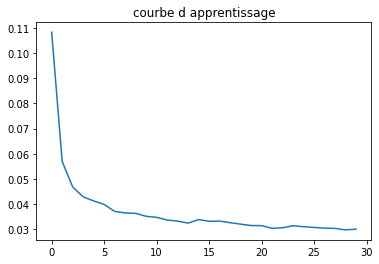

In [ ]:
plt.plot(train_losses_is)
plt.title('courbe d apprentissage')

In [ ]:
#visualisation:

fcn.eval()
batch_size_test = 3
full_target, partial_target, integrated_signals = gen_image_with_integrated_signals(batch_size_test, p)

input = integrated_signals.cuda()

output = fcn(input)


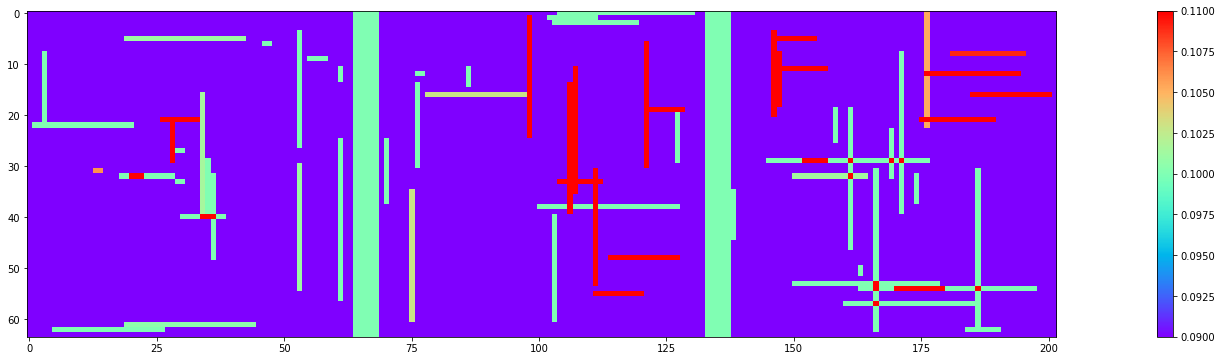

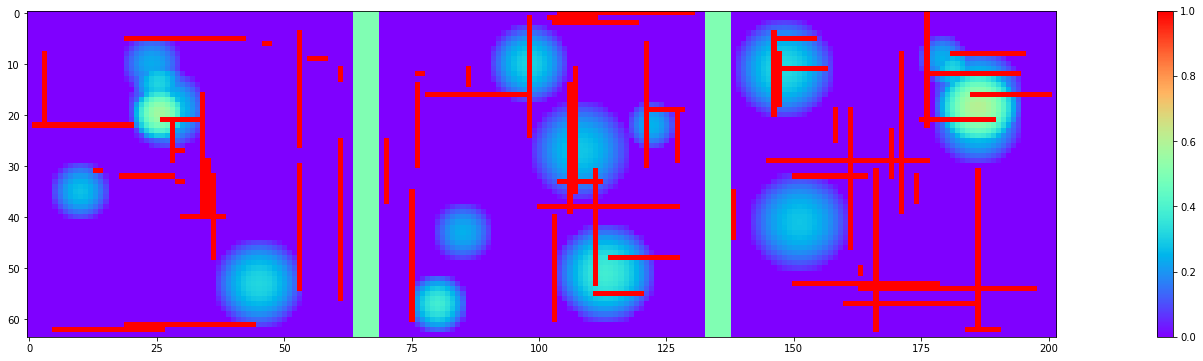

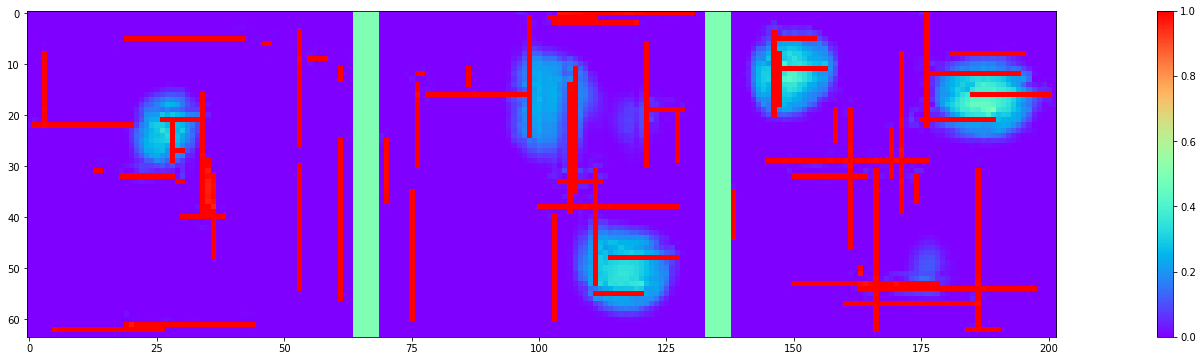

In [ ]:
fig = plt.figure(0, figsize=(36, 6))  #première lignes: entrées
voir_batch2D(input.cpu(), 6, fig, k=0, min_scale= 0.09,max_scale=0.11)
fig2 = plt.figure(1, figsize=(36, 6))  #seconde ligne: vérité terrain
voir_batch2D(full_target + (input.cpu())*10, 6, fig2, k=0, min_scale=0,max_scale=1)
fig3 = plt.figure(2, figsize=(36, 6))  #dernière ligne: sorties
voir_batch2D(output.detach().cpu() + (input.cpu())*10, 6, fig2, k=0, min_scale=0,max_scale=1.)

A trente époques, l'apprentissage n'est pas terminé; pourtant, le réseau a appris à former des plages de valeurs positives régulières:
- sous les segments les plus intenses;
- évitant les segments sur lesquels $T$ est de valeur nulle;
- discoïdes lorsque plusieurs segments intenses se recoupent.

Par contre:
- le réseau ne tient pas assez compte des segments qui traduisent une valeur moyenne faible mais non nulle.
- les artefacts sont encore nombreux (traces linéaires au sein des plages).

Une conséquence de la MAE, comparée à la MSE, c'est d'éviter un bruit strictement positif dans les zones où les segments sont absents (médiane considionnelle nulle).



**Note**: la médiane conditionnelle au signal d'entrée n'a pas de raison d'être structurée en disques. Des disques ne sont attendus que dans la situation où le problème peut être inversé (par exemple, aux endroits où les signaux d'entrée sont nombreux).

**Exercice 2**

On souhaite montrer qu'un *fcn* peut utiliser simultanément les deux types de signaux (mesures ponctuelles et données d'opportunité).
Reprendre le code de **l'exercice 1** avec les deux champs en entrée. Comparer les performances aux plans quantitatif (courbes d'apprentissage) et qualitatif. Conclure

In [ ]:
# Apprentissage avec les données ponctuelles seules:
ch_in = 1
ch_out = 1
size = 8

fcn = UNet(ch_in,ch_out,size).cuda()

optimizer = optim.Adam(fcn.parameters(), 10**(-4))

In [ ]:
nepochs = 30
nbatches = 100
batchsize = 32

train_losses_pt = []


for epoch in range(nepochs):


    print("Epoch " + str(epoch))
    epoch_losses  = []
    for i in range(nbatches):    # nbatch = datasetsize/batchsize
        #Load inputs


        full_target, partial_target, _ = gen_image_with_integrated_signals(batch_size, p)


        input = partial_target.cuda()
        target = full_target.cuda()


        optimizer.zero_grad()
        output = fcn(input)

        loss = criterion(output,target)
        loss.backward()

        optimizer.step()


        epoch_losses.append(loss.detach().cpu())

        del target, input, loss
        torch.cuda.empty_cache()

    epoch_loss = np.mean(epoch_losses)
    train_losses_pt.append(epoch_loss)

    print('epoch loss : \n')
    print(epoch_loss)

Epoch 0
epoch loss : 

0.08979923
Epoch 1
epoch loss : 

0.047109347
Epoch 2
epoch loss : 

0.04312549
Epoch 3
epoch loss : 

0.0399347
Epoch 4
epoch loss : 

0.038735703
Epoch 5
epoch loss : 

0.037555393
Epoch 6
epoch loss : 

0.036693335
Epoch 7
epoch loss : 

0.035804734
Epoch 8
epoch loss : 

0.03498278
Epoch 9
epoch loss : 

0.035908822
Epoch 10
epoch loss : 

0.034512073
Epoch 11
epoch loss : 

0.0341048
Epoch 12
epoch loss : 

0.03366023
Epoch 13
epoch loss : 

0.035830792
Epoch 14
epoch loss : 

0.03351871
Epoch 15
epoch loss : 

0.034290444
Epoch 16
epoch loss : 

0.033504672
Epoch 17
epoch loss : 

0.032999035
Epoch 18
epoch loss : 

0.034178823
Epoch 19
epoch loss : 

0.03304228
Epoch 20
epoch loss : 

0.032909263
Epoch 21
epoch loss : 

0.03349826
Epoch 22
epoch loss : 

0.03301124
Epoch 23
epoch loss : 

0.034535058
Epoch 24
epoch loss : 

0.0326632
Epoch 25
epoch loss : 

0.03381519
Epoch 26
epoch loss : 

0.032520227
Epoch 27
epoch loss : 

0.033209104
Epoch 28
epoch lo

In [ ]:
# Apprentissage avec les deux champs en entrée:
ch_in = 2
ch_out = 1
size = 8

fcn = UNet(ch_in,ch_out,size).cuda()

optimizer = optim.Adam(fcn.parameters(), 10**(-4))

In [ ]:
nepochs = 30
nbatches = 100
batch_size = 32
p = 0.5 / 100
train_losses_2ch = []


for epoch in range(nepochs):


    print("Epoch " + str(epoch))
    epoch_losses  = []
    for i in range(nbatches):    # nbatch = datasetsize/batchsize
        #Load inputs


        full_target, partial_target, integrated_signals =\
                       gen_image_with_integrated_signals(batch_size, p)


        input = torch.cat((integrated_signals.cuda(), partial_target.cuda()), dim=1)
        target = full_target.cuda()


        optimizer.zero_grad()
        output = fcn(input)

        loss = criterion(output,target)
        loss.backward()

        optimizer.step()


        epoch_losses.append(loss.detach().cpu())

        del target, input, loss
        torch.cuda.empty_cache()

    epoch_loss = np.mean(epoch_losses)
    train_losses_2ch.append(epoch_loss)

    print('epoch loss : \n')
    print(epoch_loss)


Epoch 0
epoch loss : 

0.10879896
Epoch 1
epoch loss : 

0.03943825
Epoch 2
epoch loss : 

0.03476381
Epoch 3
epoch loss : 

0.031440046
Epoch 4
epoch loss : 

0.029073462
Epoch 5
epoch loss : 

0.027966326
Epoch 6
epoch loss : 

0.027555225
Epoch 7
epoch loss : 

0.026791357
Epoch 8
epoch loss : 

0.025825327
Epoch 9
epoch loss : 

0.02568421
Epoch 10
epoch loss : 

0.025106875
Epoch 11
epoch loss : 

0.02489917
Epoch 12
epoch loss : 

0.024238555
Epoch 13
epoch loss : 

0.024048608
Epoch 14
epoch loss : 

0.023378968
Epoch 15
epoch loss : 

0.023971125
Epoch 16
epoch loss : 

0.023721498
Epoch 17
epoch loss : 

0.02326604
Epoch 18
epoch loss : 

0.022887418
Epoch 19
epoch loss : 

0.023140011
Epoch 20
epoch loss : 

0.02275478
Epoch 21
epoch loss : 

0.022788448
Epoch 22
epoch loss : 

0.022725848
Epoch 23
epoch loss : 

0.022693533
Epoch 24
epoch loss : 

0.022237234
Epoch 25
epoch loss : 

0.022422723
Epoch 26
epoch loss : 

0.021982118
Epoch 27
epoch loss : 

0.022451641
Epoch 28


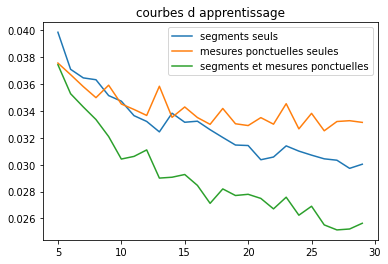

In [ ]:
plt.plot(range(5,30), train_losses_is[5:])
plt.plot(range(5,30),train_losses_pt[5:])
plt.plot(range(5,30),train_losses_2ch[5:])
plt.title('courbes d apprentissage')
plt.legend(['segments seuls', 'mesures ponctuelles seules', 'segments et mesures ponctuelles'])

Premier indice, les courbes d'apprentissage montre l'avantage  d'un entraînement avec les deux entrées concaténées.

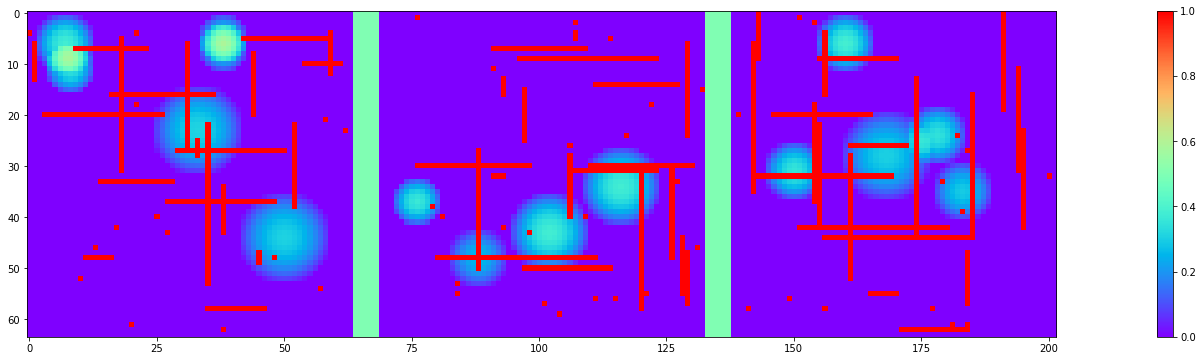

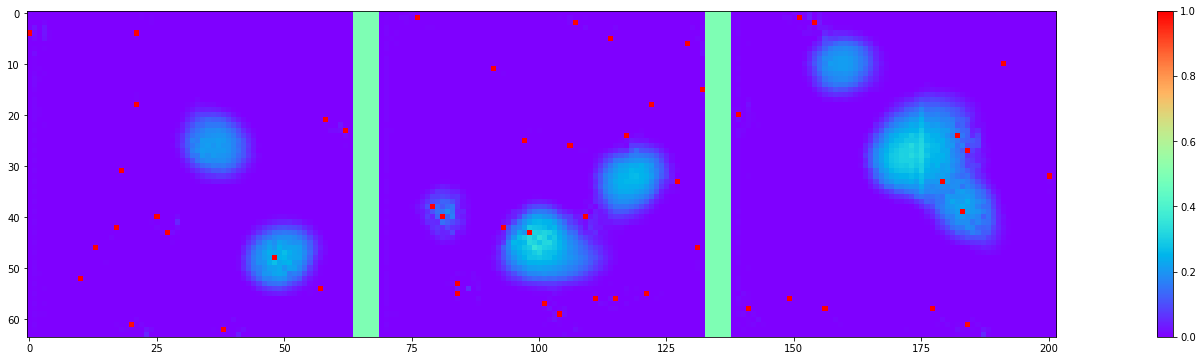

In [ ]:
fcn.eval()
batch_size_test = 3
full_target, partial_target, integrated_signals = gen_image_with_integrated_signals(batch_size_test, p)

input = torch.cat((integrated_signals.cuda(), partial_target.cuda()), dim=1)

output = fcn(input)

output = output.detach().cpu()
input = input.detach().cpu()
input_seg = input[:,[0],:,:]
input_point = input[:,[1],:,:]

full_target[input_seg > 0] = 1
full_target[input_point >= 0] = 1

fig2 = plt.figure(1, figsize=(36, 6))  #première ligne: vérité terrain
voir_batch2D(full_target, 6, fig2, k=0, min_scale=0,max_scale=1)
fig3 = plt.figure(2, figsize=(36, 6))  #seconde ligne: sorties
voir_batch2D(output.detach().cpu() + (input.cpu()[:,[1],:,:]>=0).float(), 6, fig2, k=0, min_scale=0,max_scale=1)


Sur les images en sortie, on constate que le réseau tient aussi bien compte des segments que des points pour former des plages de valeurs positives.